# References

This notebook contains analysis of certificate references in Common Criteria certificates.

The notebook has two parts, an analysis part and a network visualization part.
But first some common initialization and data loading.

In [ ]:
from __future__ import annotations
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sec_certs.dataset.cc import CCDataset
from sec_certs.model.references.reference_finder import ReferenceFinder
from sec_certs.sample.cc_certificate_id import CertificateId
import pandas as pd
import seaborn as sns
import numpy as np
import sys
from tqdm import tqdm
from pathlib import Path


sys.path.insert(0, "./../")
from fixed_sankey_plot import sankey

%matplotlib inline

# matplotlib.use("pgf")
sns.set_theme(style='white')
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 6.5
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["ytick.left"] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.major.pad'] = 0
plt.rcParams["xtick.bottom"] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.major.pad'] = 0
plt.rcParams["pgf.texsystem"] = "pdflatex"
plt.rcParams["font.family"] = "serif"
plt.rcParams["text.usetex"] = True
plt.rcParams["pgf.rcfonts"] = False
plt.rcParams["axes.titlesize"] = 8
plt.rcParams["legend.handletextpad"] = 0.3
plt.rcParams['lines.markersize'] = 4
plt.rcParams['savefig.pad_inches'] = 0.01
sns.set_palette("deep")

#plt.style.use("seaborn-whitegrid")
#sns.set_palette("deep")
#sns.set_context("notebook")  # Set to "paper" for use in paper :)

#plt.rcParams['figure.figsize'] = (10, 6)

RESULTS_DIR = Path("./results/references")
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

In [56]:
# Initialize
dset = CCDataset.from_web_latest()

In [57]:
df = dset.to_pandas()
df_id_rich = df.loc[df.cert_id.notnull()].copy()

In [58]:
# Retrospectivaly limit the validity of each certificate to 5 years to account for the policy change. Draw plots with it.
df_id_rich["longer_than_5_years"] = df_id_rich["not_valid_after"] - df_id_rich["not_valid_before"] > pd.Timedelta(days=5 * 365)
df_id_rich.loc[df_id_rich["longer_than_5_years"], "not_valid_after"] = df_id_rich.loc[df_id_rich["longer_than_5_years"], "not_valid_before"] + pd.Timedelta(days=5 * 365)

## Reference analysis


### References to certificate with unknown IDs

In [ ]:
def ref_lookup(kw_attr):
            def func(cert):
                kws = getattr(cert.pdf_data, kw_attr)
                if not kws:
                    return set()
                res = set()
                for scheme, matches in kws["cc_cert_id"].items():
                    for match in matches:
                        try:
                            canonical = CertificateId(scheme, match).canonical
                            res.add(canonical)
                        except Exception:
                            res.add(match)
                return res

            return func

report_finder = ReferenceFinder()
report_finder.fit(dset.certs, lambda cert: cert.heuristics.cert_id, ref_lookup("report_keywords"))
report_unknown_references = report_finder.unknown_references

st_finder = ReferenceFinder()
st_finder.fit(dset.certs, lambda cert: cert.heuristics.cert_id, ref_lookup("st_keywords"))
st_unknown_references = st_finder.unknown_references

# References are stored in `report_unknown_references` and `st_unknown_references` for further analysis

### Count numbers of reference-rich certificates

- From the numbers follows that whenever a certificate is directly referencing some else, it also indirectly references some else
- We have more outgoing references than ingoing references, which kinda makes sense. You don't have to be aware that some other cert references you

In [59]:
df["has_outgoing_direct_references"] = df.directly_referencing.notnull()
df["has_incoming_direct_references"] = df.directly_referenced_by.notnull()
df["has_outgoing_indirect_references"] = df.indirectly_referencing.notnull()
df["has_incoming_indirect_references"] = df.indirectly_referenced_by.notnull()

df_id_rich["has_outgoing_direct_references"] = df_id_rich.directly_referencing.notnull()
df_id_rich["has_incoming_direct_references"] = df_id_rich.directly_referenced_by.notnull()
df_id_rich["has_outgoing_indirect_references"] = df_id_rich.indirectly_referencing.notnull()
df_id_rich["has_incoming_indirect_references"] = df_id_rich.indirectly_referenced_by.notnull()

archived_cert_id_list = set(df_id_rich[df_id_rich.status == "archived"].cert_id)

def len_if_exists(x) -> int:
    return len(x) if pd.notnull(x) else 0

df_id_rich["n_references"] = df_id_rich.directly_referencing.map(len_if_exists)
df_id_rich["n_trans_references"] = df_id_rich.indirectly_referencing.map(len_if_exists)
df_id_rich["n_referenced_by"] = df_id_rich.directly_referenced_by.map(len_if_exists)
df_id_rich["n_trans_referenced_by"] = df_id_rich.indirectly_referenced_by.map(len_if_exists)

n_ref_smartcards = df_id_rich.loc[(df_id_rich.directly_referencing.notnull()) & (df_id_rich.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems")].shape[0]
n_ref_others = df_id_rich.loc[(df_id_rich.directly_referencing.notnull()) & (df_id_rich.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems")].shape[0]
print(f"Number of smartcard certificates that reference some other certificate: {n_ref_smartcards}")
print(f"Number of non-smartcard certificates that reference some other certificate: {n_ref_others}")

Number of smartcard certificates that reference some other certificate: 1227
Number of non-smartcard certificates that reference some other certificate: 336


## Distribution of references and certificate reach

/Users/adam/phd/projects/certificates/sec-certs/venv/lib/python3.8/site-packages/seaborn/categorical.py:3200: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


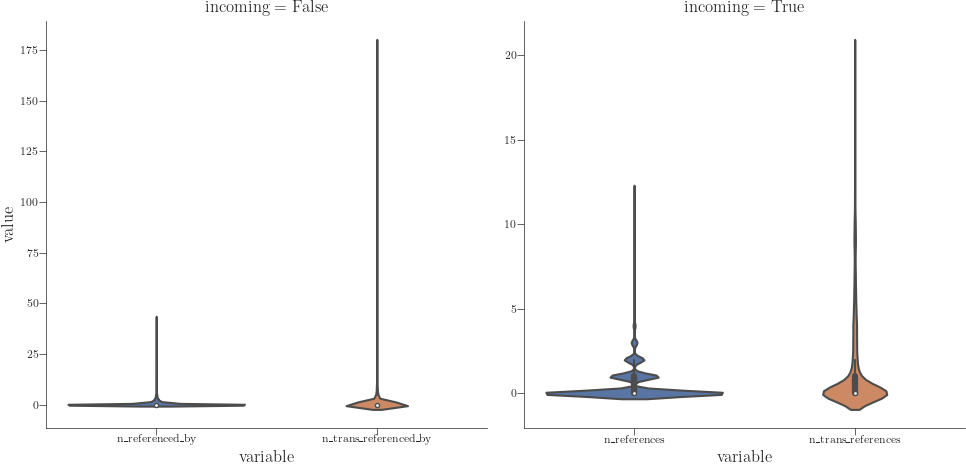

In [60]:
df_melted = df_id_rich[["n_references", "n_trans_references", "n_referenced_by", "n_trans_referenced_by"]].melt()
df_melted["incoming"] = df_melted.variable.map(lambda x: False if x.endswith("by") else True)
sns.catplot(data=df_melted, kind="violin", x="variable", y="value", col="incoming", sharex=False, sharey=False)
plt.savefig(RESULTS_DIR / "violin_n_references.pdf", bbox_inches="tight")
plt.show()

## Evolution of certificate reach for top-10 certificates

In [61]:
top_10 = df_id_rich.n_trans_referenced_by.sort_values(ascending=False).head(10)
top_10_cert_ids = df_id_rich.loc[top_10.index].cert_id
top_10

dgst
9be76c10474e0c80    178
13c393fa406a72cb    120
2d835bff00514238    101
3984580c5700b85f     88
d12cc4580cb099f8     85
a4d0e44f4527180f     84
ab88698a0c6ee1bb     83
5cdef03a3004a6ff     83
5e06be752f7bf01a     83
8aca11dd8e33c964     80
Name: n_trans_referenced_by, dtype: int64

100%|██████████| 10/10 [01:29<00:00,  8.94s/it]


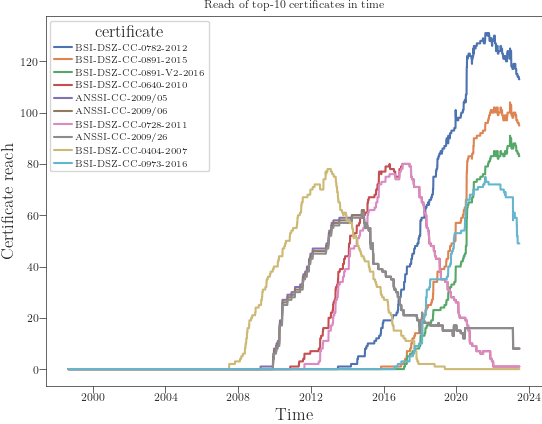

In [62]:
def find_reach_over_time(df: pd.DataFrame, cert_id: str, date_range: pd.DatetimeIndex) -> pd.Series:
    df_copy = df.copy()
    df_copy["is_referenced_by"] = df_copy.indirectly_referencing.map(lambda x: False if pd.isnull(x) else cert_id in x)
    df_subset = df_copy.loc[df_copy.is_referenced_by]
    dct = {}
    for date in date_range:
        dct[date] = df_subset.loc[(date >= df_subset.not_valid_before) & (date <= df_subset.not_valid_after)].shape[0]
    return pd.Series(dct, name=cert_id)

certs_with_top_reach = top_10_cert_ids.tolist()
date_range = pd.date_range(df_id_rich.not_valid_before.min(), df_id_rich.not_valid_before.max())
data = [find_reach_over_time(df_id_rich, x, date_range) for x in tqdm(certs_with_top_reach)]
df_reach_evolution = pd.concat(data, axis=1)

df_reach_evolution.index.name = "date"
df_reach_evolution = df_reach_evolution.reset_index()


df_reach_evolution_melted = df_reach_evolution.melt(id_vars="date", var_name="certificate", value_name="reach")

g = sns.lineplot(data=df_reach_evolution_melted, x="date", y="reach", hue="certificate")
g.set(title="Reach of top-10 certificates in time", xlabel="Time", ylabel="Certificate reach")
plt.savefig(RESULTS_DIR / "lineplot_top_certificate_reach.pdf", bbox_inches="tight")
plt.show()

## Average number of references & certificate reach over time

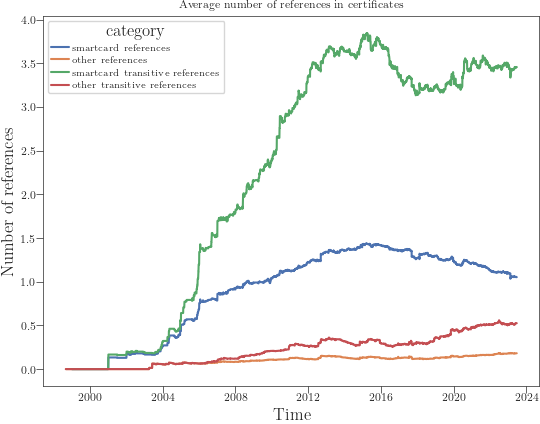

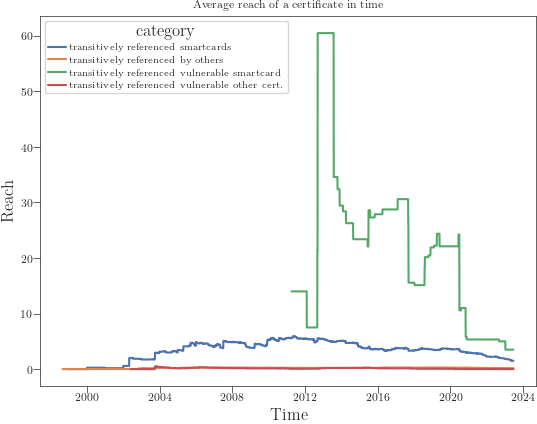

In [63]:
def compute_avg_references(df: pd.DataFrame, smartcards: bool, variable: str, date_range: pd.DateTimeIndex) -> dict:
    """
    Computes a dictionary (from which series can be created) where index is date and value is average 'variable' value
    for certificates that were valid at that time, coming from either smardcards or other categories.
    E.g., variable can be `directly_referencing`.
    """
    df_copy = df.copy()
    df_copy["target_variable"] = df[variable].map(lambda x: len(x) if pd.notnull(x) else 0)

    dct = {}
    for date in date_range:
        if smartcards:
            dct[date] = df_copy.loc[
                (date >= df_copy.not_valid_before)
                & (date <= df_copy.not_valid_after)
                & (df_copy.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems")
            ]["target_variable"].mean()
        else:
            dct[date] = df_copy.loc[
                (date >= df_copy.not_valid_before)
                & (date <= df_copy.not_valid_after)
                & (df_copy.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems")
            ]["target_variable"].mean()
    return dct

date_range =  pd.date_range(df_id_rich.not_valid_before.min(), df_id_rich.not_valid_before.max())

refs_smartcards = compute_avg_references(df_id_rich, True, "directly_referencing", date_range)
trans_refs_smartcards = compute_avg_references(df_id_rich, True, "indirectly_referencing", date_range)
refs_others = compute_avg_references(df_id_rich, False, "directly_referencing", date_range)
trans_refs_others = compute_avg_references(df_id_rich, False, "indirectly_referencing", date_range)
df_avg_num_refs = pd.concat(
    [
        pd.Series(refs_smartcards, name="smartcard references"),
        pd.Series(refs_others, name="other references"),
        pd.Series(trans_refs_smartcards, name="smartcard transitive references"),
        pd.Series(trans_refs_others, name="other transitive references"),
    ],
    axis=1,
)
df_avg_num_refs.index.name = "date"
df_avg_num_refs = df_avg_num_refs.reset_index()
df_avg_num_refs_melted = df_avg_num_refs.melt(id_vars=["date"], var_name="category", value_name="n_references")

reach_smartcards = compute_avg_references(df_id_rich, True, "indirectly_referenced_by", date_range)
reach_others = compute_avg_references(df_id_rich, False, "indirectly_referenced_by", date_range)

df_vulnerable = df_id_rich.loc[df_id_rich.related_cves.notnull()]
reach_vuln_smartcards = compute_avg_references(df_vulnerable, True, "indirectly_referenced_by", date_range)
reach_vuln_others = compute_avg_references(df_vulnerable, False, "indirectly_referenced_by", date_range)

df_avg_reach = pd.concat(
    [
        pd.Series(reach_smartcards, name="transitively referenced smartcards"),
        pd.Series(reach_others, name="transitively referenced by others"),
        pd.Series(reach_vuln_smartcards, name="transitively referenced vulnerable smartcard"),
        pd.Series(reach_vuln_others, name="transitively referenced vulnerable other cert."),
    ],
    axis=1,
)
df_avg_reach.index.name = "date"
df_avg_reach = df_avg_reach.reset_index()
df_avg_reach_melted = df_avg_reach.melt(id_vars=["date"], var_name="category", value_name="certificate reach")

g = sns.lineplot(data=df_avg_num_refs_melted, x="date", y="n_references", hue="category")
g.set(title="Average number of references in certificates", xlabel="Time", ylabel="Number of references")
plt.savefig(RESULTS_DIR / "lineplot_avg_n_references.pdf", bbox_inches="tight")
plt.show()

g = sns.lineplot(data=df_avg_reach_melted, x="date", y="certificate reach", hue="category", errorbar=None)
g.set(title="Average reach of a certificate in time", xlabel="Time", ylabel="Reach")
plt.savefig(RESULTS_DIR / "lineplot_avg_reach.pdf", bbox_inches="tight")
plt.show()


## Number of active vs. number of reference-rich certificates in time

100%|██████████| 9061/9061 [01:11<00:00, 127.30it/s]


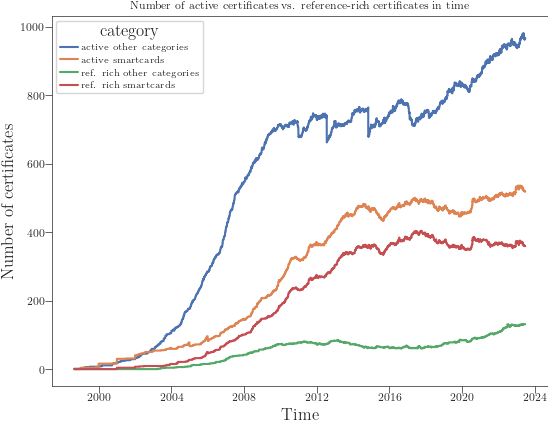

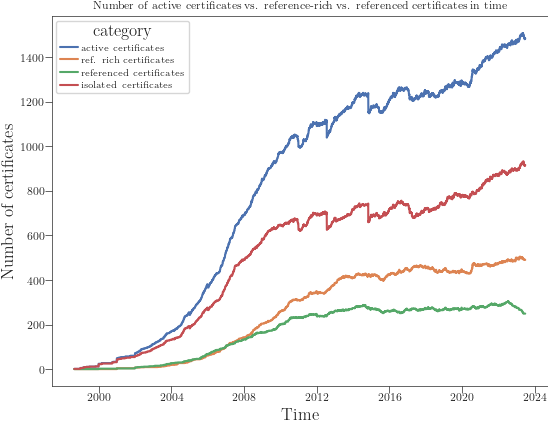

In [64]:
date_range = pd.date_range(df_id_rich.not_valid_before.min(), df_id_rich.not_valid_before.max())
dct_active_all = {}
dct_reference_rich_all = {}
dct_referenced_all = {}
dct_isolated_all = {}
dct_active_others = {}
dct_reference_rich_others = {}
dct_active_smartcards = {}
dct_reference_rich_smartcards = {}
for date in tqdm(date_range):
    active_certs = df_id_rich.loc[(date >= df_id_rich.not_valid_before) & (date <= df_id_rich.not_valid_after)]
    dct_active_all[date] = active_certs.shape[0]
    dct_isolated_all[date] = active_certs.loc[(active_certs.n_references == 0) & (active_certs.n_referenced_by == 0)].shape[0]
    dct_active_others[date] = active_certs.loc[
        active_certs.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems"
    ].shape[0]
    dct_active_smartcards[date] = active_certs.loc[
        active_certs.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems"
    ].shape[0]
    dct_reference_rich_all[date] = active_certs.loc[active_certs.n_references > 0].shape[0]
    dct_referenced_all[date] = active_certs.loc[active_certs.n_referenced_by > 0].shape[0]
    dct_reference_rich_others[date] = active_certs.loc[
        (active_certs.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems")
        & (active_certs.n_references > 0)
    ].shape[0]
    dct_reference_rich_smartcards[date] = active_certs.loc[
        (active_certs.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems")
        & (active_certs.n_references > 0)
    ].shape[0]

df_active_vs_ref_rich = pd.concat(
    [
        pd.Series(dct_active_others, name="active other categories"),
        pd.Series(dct_active_smartcards, name="active smartcards"),
        pd.Series(dct_reference_rich_others, name="ref. rich other categories"),
        pd.Series(dct_reference_rich_smartcards, name="ref. rich smartcards"),
    ],
    axis=1,
)

df_active_vs_ref_rich.index.name = "date"
df_active_vs_ref_rich = df_active_vs_ref_rich.reset_index()

df_active_vs_ref_rich_melted = df_active_vs_ref_rich.melt(
    id_vars=["date"], var_name="category", value_name="number of certificates"
)
g = sns.lineplot(data=df_active_vs_ref_rich_melted, x="date", y="number of certificates", hue="category")
g.set(
    title="Number of active certificates vs. reference-rich certificates in time",
    xlabel="Time",
    ylabel="Number of certificates",
)
plt.savefig(RESULTS_DIR / "lienplot_n_active_certs_vs_n_references.pdf", bbox_inches="tight")
plt.show()


df_summary_references = pd.concat(
    [
        pd.Series(dct_active_all, name="active certificates"),
        pd.Series(dct_reference_rich_all, name="ref. rich certificates"),
        pd.Series(dct_referenced_all, name="referenced certificates"),
        pd.Series(dct_isolated_all, name="isolated certificates"),
    ], axis=1
)
df_summary_references.index.name = "date"
df_summary_references = df_summary_references.reset_index()
df_summary_references_melted = df_summary_references.melt(id_vars=["date"], var_name="category", value_name="number of certificates")

g = sns.lineplot(data=df_summary_references_melted, x="date", y="number of certificates", hue="category", errorbar=None)
g.set(
    title="Number of active certificates vs. reference-rich vs. referenced certificates in time",
    xlabel="Time",
    ylabel="Number of certificates",
)
plt.savefig(RESULTS_DIR / "lineplot_references_summary.pdf", bbox_inches="tight")
plt.show()


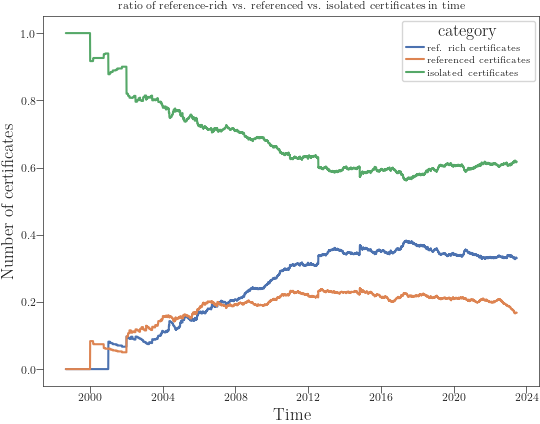

In [66]:
df_ratios = df_summary_references.copy()
df_ratios["ref. rich certificates"] = df_ratios["ref. rich certificates"] / df_ratios["active certificates"]
df_ratios["referenced certificates"] = df_ratios["referenced certificates"] / df_ratios["active certificates"]
df_ratios["isolated certificates"] = df_ratios["isolated certificates"] / df_ratios["active certificates"]
df_ratios = df_ratios.drop(columns=["active certificates"])
df_ratios_melted = df_ratios.melt(id_vars=["date"], var_name="category", value_name="ratio of certificates")

g = sns.lineplot(data=df_ratios_melted, x="date", y="ratio of certificates", hue="category", errorbar=None)
g.set(
    title="ratio of reference-rich vs. referenced vs. isolated certificates in time",
    xlabel="Time",
    ylabel="Number of certificates",
)
plt.savefig(RESULTS_DIR / "lineplot_reference_ratio.pdf", bbox_inches="tight")
plt.show()

## Number of active certificates that reference some archived certificate in time

100%|██████████| 9061/9061 [01:25<00:00, 106.29it/s]


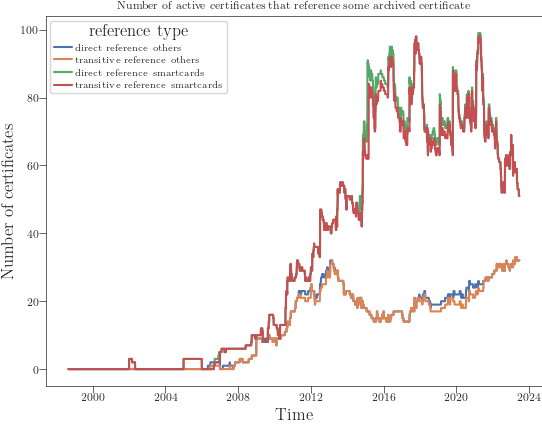

In [67]:
date_range = pd.date_range(df_id_rich.not_valid_before.min(), df_id_rich.not_valid_before.max())
dct_direct_others = {}
dct_direct_smartcards = {}
dct_transitive_others = {}
dct_transitive_smartcards = {}
for date in tqdm(date_range):
    active_certs = df_id_rich.loc[(date >= df_id_rich.not_valid_before) & (date <= df_id_rich.not_valid_after)].copy()
    active_certs_cert_ids = set(active_certs["cert_id"].tolist())
    active_certs["no_intersection"] = active_certs.directly_referencing.map(
        lambda x: False if pd.isnull(x) else not x.intersection(active_certs_cert_ids)
    )
    active_certs["no_transitive_intersection"] = active_certs.indirectly_referencing.map(
        lambda x: False if pd.isnull(x) else not x.intersection(active_certs_cert_ids)
    )
    dct_direct_others[date] = active_certs.loc[
        (active_certs.no_intersection)
        & (active_certs.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]
    dct_transitive_others[date] = active_certs.loc[
        (active_certs.no_transitive_intersection)
        & (active_certs.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]
    dct_direct_smartcards[date] = active_certs.loc[
        (active_certs.no_intersection)
        & (active_certs.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]
    dct_transitive_smartcards[date] = active_certs.loc[
        (active_certs.no_transitive_intersection)
        & (active_certs.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]

df_refs_to_archived = pd.concat(
    [
        pd.Series(dct_direct_others, name="direct reference others"),
        pd.Series(dct_transitive_others, name="transitive reference others"),
        pd.Series(dct_direct_smartcards, name="direct reference smartcards"),
        pd.Series(dct_transitive_smartcards, name="transitive reference smartcards"),
    ],
    axis=1,
)
df_refs_to_archived.index.name = "date"
df_refs_to_archived = df_refs_to_archived.reset_index()
df_refs_to_archived_melted = df_refs_to_archived.melt(
    id_vars=["date"], var_name="reference type", value_name="number of certificates"
)

g = sns.lineplot(data=df_refs_to_archived_melted, x="date", y="number of certificates", hue="reference type")
g.set(
    title="Number of active certificates that reference some archived certificate",
    xlabel="Time",
    ylabel="Number of certificates",
)
plt.savefig(RESULTS_DIR / "lienplot_active_certs_referencing_archived.pdf", bbox_inches="tight")
plt.show()


## Certificates referencing vulnerable certificates in time

100%|██████████| 9061/9061 [01:19<00:00, 114.14it/s]


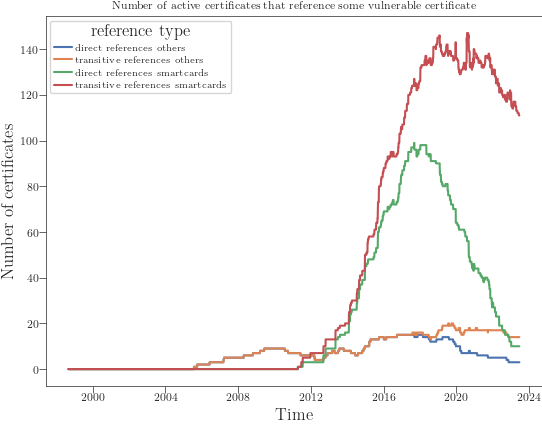

In [68]:
date_range = pd.date_range(df_id_rich.not_valid_before.min(), df_id_rich.not_valid_before.max())
vulnerable_cert_ids = set(df_id_rich.loc[df_id_rich.related_cves.notnull()].cert_id.tolist())
dct_direct_others = {}
dct_transitive_others = {}
dct_direct_smartcards = {}
dct_transitive_smartcards = {}
for date in tqdm(date_range):
    active_certs = df_id_rich.loc[(date >= df_id_rich.not_valid_before) & (date <= df_id_rich.not_valid_after)].copy()
    active_certs["directly_references_vulnerable_cert"] = active_certs.directly_referencing.map(
        lambda x: False if pd.isnull(x) else bool(x.intersection(vulnerable_cert_ids))
    )
    active_certs["transitively_references_vulnerable_cert"] = active_certs.indirectly_referencing.map(
        lambda x: False if pd.isnull(x) else bool(x.intersection(vulnerable_cert_ids))
    )
    dct_direct_others[date] = active_certs.loc[
        (active_certs.directly_references_vulnerable_cert)
        & (active_certs.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]
    dct_transitive_others[date] = active_certs.loc[
        (active_certs.transitively_references_vulnerable_cert)
        & (active_certs.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]
    dct_direct_smartcards[date] = active_certs.loc[
        (active_certs.directly_references_vulnerable_cert)
        & (active_certs.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]
    dct_transitive_smartcards[date] = active_certs.loc[
        (active_certs.transitively_references_vulnerable_cert)
        & (active_certs.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]

df_references_vuln = pd.concat(
    [
        pd.Series(dct_direct_others, name="direct references others"),
        pd.Series(dct_transitive_others, name="transitive references others"),
        pd.Series(dct_direct_smartcards, name="direct references smartcards"),
        pd.Series(dct_transitive_smartcards, name="transitive references smartcards"),
    ],
    axis=1,
)
df_references_vuln.index.name = "date"
df_references_vuln = df_references_vuln.reset_index()
df_references_vuln_melted = df_references_vuln.melt(
    id_vars="date", var_name="reference type", value_name="number of certificates"
)

g = sns.lineplot(data=df_references_vuln_melted, x="date", y="number of certificates", hue="reference type")
g.set(
    title="Number of active certificates that reference some vulnerable certificate",
    xlabel="Time",
    ylabel="Number of certificates",
)
plt.savefig(RESULTS_DIR / "lienplot_active_certs_referencing_vulnerable.pdf", bbox_inches="tight")
plt.show()


### Plot direct references per category (count plot)

In [69]:
figure, axes = plt.subplots(1, 2)
figure.set_size_inches(16, 10)
figure.set_tight_layout(True)

col_to_depict = ["has_outgoing_direct_references", "has_incoming_direct_references"]

for index, col in enumerate(col_to_depict):
    countplot = sns.countplot(data=df, x="category", hue=col, ax=axes[index])
    countplot.set(
        xlabel="Category",
        ylabel="Outgoing direct references",
        title=f"Countplot of {' '.join(col.split('_'))}",
    )
    countplot.tick_params(axis="x", rotation=90)
    countplot.legend(title=' '.join(col.split('_')), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.savefig(str(RESULTS_DIR / "references_countplot.pdf"), bbox_inches="tight")
plt.close(figure)


### Plot direct references per category (Sankey diagram)

In [70]:
cert_id_to_category_mapping = dict(zip(df.cert_id, df.category))
cert_id_to_category_mapping[np.NaN] = "No references"

exploded = df_id_rich.loc[:, ["category", "directly_referencing"]].explode("directly_referencing")
exploded["ref_category"] = exploded.directly_referencing.map(lambda x: cert_id_to_category_mapping[x] if pd.notnull(x) else np.nan)
exploded = exploded.loc[exploded.ref_category.notnull()]

exploded_with_refs = exploded.loc[exploded.ref_category != "No references"]

all_categories = set(exploded.category.unique()) | set(exploded.ref_category.unique())
colors = list(sns.color_palette("hls", len(all_categories), as_cmap=False).as_hex())
color_dict = dict(zip(all_categories, colors))

figure, axes = plt.subplots(1, 1)
figure.set_size_inches(24, 10)
figure.set_tight_layout(True)

sankey(exploded.category, exploded.ref_category, colorDict=color_dict, leftLabels=list(exploded.category.unique()), rightLabels=list(exploded.ref_category.unique()), fontsize=12, ax=axes)

figure.savefig(str(RESULTS_DIR / "category_references.pdf"), bbox_inches="tight")
figure.savefig(str(RESULTS_DIR / "category_references.pgf"), bbox_inches="tight")
plt.close(figure)

### Plot direct references per scheme (count plot)

In [71]:
figure, axes = plt.subplots(1, 2)
figure.set_size_inches(14, 4)
figure.set_tight_layout(True)

col_to_depict = ["has_outgoing_direct_references", "has_incoming_direct_references"]

for index, col in enumerate(col_to_depict):
    countplot = sns.countplot(data=df, x="scheme", hue=col, ax=axes[index])
    countplot.set(
        xlabel="Category",
        ylabel="Outgoing direct references",
        title=f"Countplot of {' '.join(col.split('_'))}",
    )
    countplot.tick_params(axis="x", rotation=90)
    countplot.legend(title=' '.join(col.split('_')), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.savefig(str(RESULTS_DIR / "references_per_scheme_countplot.pdf"), bbox_inches="tight")
plt.close(figure)

### Number of certificates referencing archived certificates (count plot)

Number of certificates that reference some archived certificate: 978


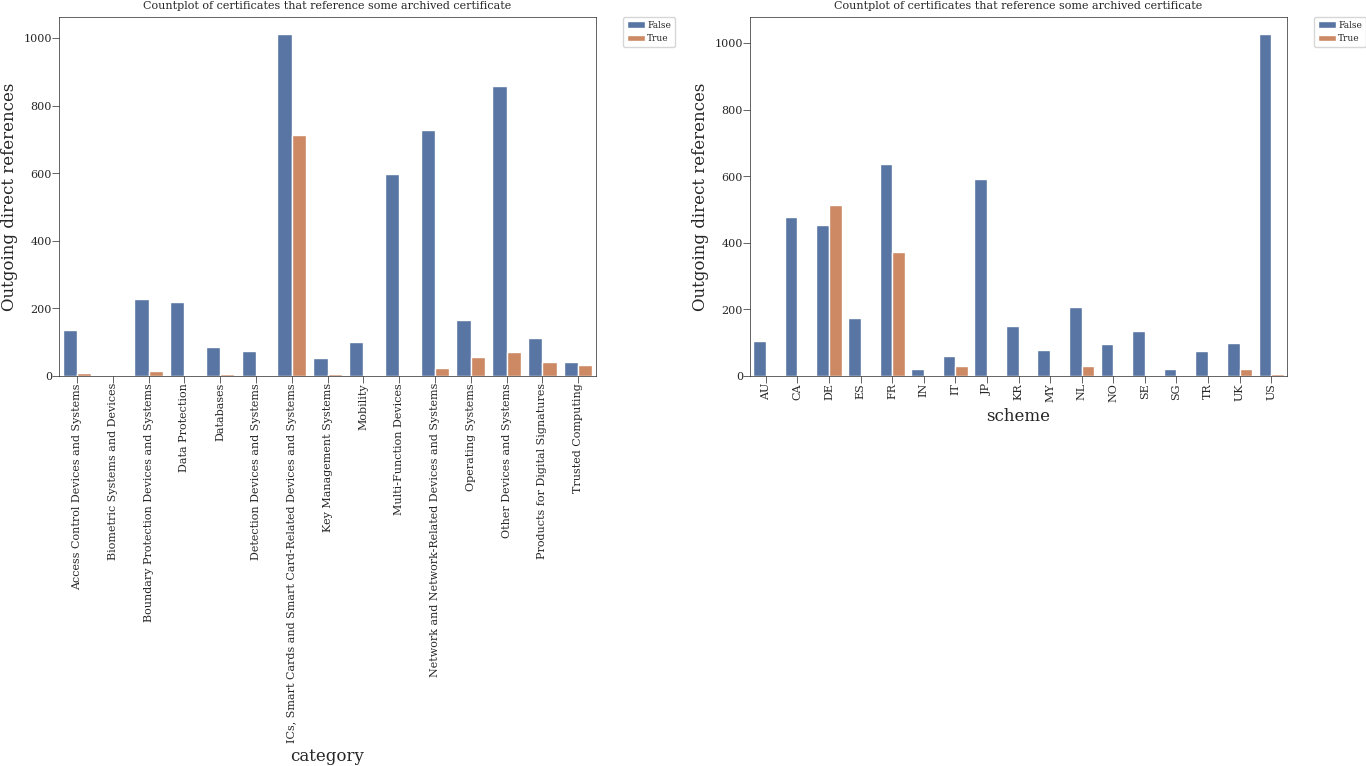

In [72]:
def references_archived_cert(references):
    if pd.isnull(references):
        return False

    return any([x in cert_ids] for x in references)

cert_ids = set(df.loc[((df.cert_id.notnull()) & (df.status == "archived")), "cert_id"].tolist())
df["references_archived_cert"] = df.directly_referenced_by.map(references_archived_cert)

# TODO: We should limit on the number of certificates that referenced an archived certificate at some point where they were active as well.
print(f"Number of certificates that reference some archived certificate: {df.loc[df.references_archived_cert].shape[0]}")

col_to_depict = ["category", "scheme"]

figure, axes = plt.subplots(1, 2)
figure.set_size_inches(14, 8)
figure.set_tight_layout(True)

for index, col in enumerate(col_to_depict):
    countplot = sns.countplot(data=df, x=col, hue="references_archived_cert", ax=axes[index])
    countplot.set(
        xlabel=col,
        ylabel="Outgoing direct references",
        title="Countplot of certificates that reference some archived certificate",
    )
    countplot.tick_params(axis="x", rotation=90)
    countplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

### Count scheme references (Sankey diagram)

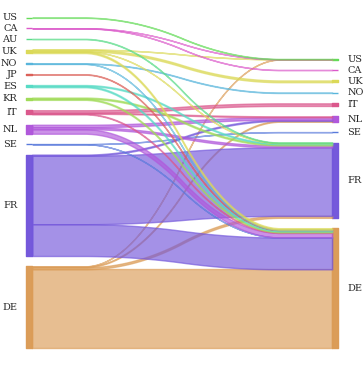

In [73]:
cert_id_to_scheme_mapping = dict(zip(df.cert_id, df.scheme))

df_ref_rich = df_id_rich.loc[df.directly_referencing.notnull()]
exploded = df_ref_rich.loc[:, ["scheme", "directly_referencing"]].explode("directly_referencing")

exploded["ref_scheme"] = exploded.directly_referencing.map(cert_id_to_scheme_mapping)
exploded = exploded.loc[exploded.ref_scheme.notnull()]

all_schemes = set(exploded.scheme.unique()) | set(exploded.ref_scheme.unique())
colors = list(sns.color_palette("hls", len(all_schemes), as_cmap=False).as_hex())
color_dict = dict(zip(all_schemes, colors))

figure, axes = plt.subplots(1, 1)
figure.set_size_inches(4, 4)
figure.set_tight_layout(True)

sankey(exploded.scheme, exploded.ref_scheme, colorDict=color_dict, leftLabels=list(exploded.scheme.unique()), rightLabels=list(exploded.ref_scheme.unique()), fontsize=7, ax=axes)

figure.savefig(str(RESULTS_DIR / "scheme_references.pdf"), bbox_inches="tight")
figure.savefig(str(RESULTS_DIR / "scheme_references.pgf"), bbox_inches="tight")
plt.show()
plt.close(figure)

## Reference network visualization

In [34]:
certs_with_ids = {cert.heuristics.cert_id: cert for cert in dset if cert.heuristics.cert_id}

print(f"Certificates in dataset: {len(dset)}")
print(f"Certificates with extracted IDs: {len(certs_with_ids)}")

Certificates in dataset: 5393
Certificates with extracted IDs: 5239


### Certificate report references

In [36]:
refs_cr = nx.DiGraph()
for cert_id, cert in certs_with_ids.items():
    refs_cr.add_node(cert_id, cert=cert)
for cert_id, cert in certs_with_ids.items():
    if cr_refs := cert.heuristics.report_references.directly_referencing:
        for ref_id in cr_refs:
            if ref_id in certs_with_ids:
                refs_cr.add_edge(cert_id, ref_id, type=("cr",))
print(f"References in certificate reports: {len(refs_cr.edges)}")

References in certificate reports: 2410


### Security target references

In [37]:
refs_st = nx.DiGraph()
for cert_id, cert in certs_with_ids.items():
    refs_st.add_node(cert_id, cert=cert)
for cert_id, cert in certs_with_ids.items():
    if st_refs := cert.heuristics.st_references.directly_referencing:
        for ref_id in st_refs:
            if ref_id in certs_with_ids:
                refs_st.add_edge(cert_id, ref_id, type=("st",))
print(f"References in security targets: {len(refs_st.edges)}")

References in security targets: 987


### Combined references

In [38]:
refs = nx.DiGraph()
for cert_id, cert in certs_with_ids.items():
    refs.add_node(cert_id, cert=cert)

for cert_id, cert in certs_with_ids.items():
    cr_refs = cert.heuristics.report_references.directly_referencing
    st_refs = cert.heuristics.st_references.directly_referencing
    cr_refs = set(cr_refs) if cr_refs is not None else set()
    st_refs = set(st_refs) if st_refs is not None else set()
    both = cr_refs.union(st_refs)
    for ref in both:
        if ref not in certs_with_ids:
            continue
        if ref in cr_refs and ref not in st_refs:
            refs.add_edge(cert_id, ref, type=("cr", ))
        elif ref in st_refs and ref not in cr_refs:
            refs.add_edge(cert_id, ref, type=("st", ))
        else:
            refs.add_edge(cert_id, ref, type=("cr", "st"))
print(f"Combined references (not double counted): {len(refs.edges)}")

Combined references (not double counted): 2665


### Certificate overview
Enter the certificate you are interested in below and see its reference graph component.

In [ ]:
cert_id = "ANSSI-CC-2019/02"

In [39]:
cert = certs_with_ids.get(cert_id)
if cert is None:
    print(f"Certificate with id {cert_id} is not present in the dataset.")

for component in nx.weakly_connected_components(refs):
    if cert_id in component:
        break

view = nx.subgraph_view(refs, lambda node: node in component)
print(f"Certificate with id {cert_id}:")
print(f" - is in a component with {len(view.nodes)} certificates and {len(view.edges)} references.")
print(f" - references {list(view[cert_id].keys())}")
print(f" - is referenced by {list(view.predecessors(cert_id))}")
print(f" - its page is at https://seccerts.org/cc/{cert.dgst}/")

Certificate with id ANSSI-CC-2014/76:
 - is in a component with 45 certificates and 57 references.
 - references ['BSI-DSZ-CC-0917-2014']
 - is referenced by ['ANSSI-CC-2015/31']
 - its page is at https://seccerts.org/cc/09b17cb9b3c8b1bb/


In [ ]:
nx.draw(view, pos=nx.planar_layout(view), with_labels=True)

## Some graph metrics
From <https://dataground.io/2021/09/29/simple-graph-metrics-networkx-for-beginners/> and
<https://theslaps.medium.com/centrality-metrics-via-networkx-python-e13e60ba2740>.
Also good <https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/>

In [40]:
print(f"Density = {nx.density(refs)}")
print(f"Transitivity = {nx.transitivity(refs)}")

Density = 9.71143305696016e-05
Transitivity = 0.28883774453394706


In [41]:
print("Degree centrality <Popularity> (top 20):")
degree_centrality_vals = [(node, val) for node, val in nx.degree_centrality(refs).items()]
degree_centrality_vals.sort(key=lambda pair: pair[1], reverse=True)
for pair in degree_centrality_vals[:20]:
    print(f"\t{pair[0]} = {pair[1]}")

Degree centrality <Popularity> (top 20):
	BSI-DSZ-CC-0555-2009 = 0.00859106529209622
	BSI-DSZ-CC-0410-2007 = 0.00859106529209622
	ANSSI-CC-2010/02 = 0.008209240168003056
	BSI-DSZ-CC-0829-2012 = 0.0061092019854906456
	BSI-DSZ-CC-0837-V2-2014 = 0.005918289423444063
	BSI-DSZ-CC-0813-2012 = 0.00572737686139748
	BSI-DSZ-CC-1059-2018 = 0.005154639175257732
	BSI-DSZ-CC-0891-V2-2016 = 0.004581901489117984
	BSI-DSZ-CC-1040-2019 = 0.004390988927071402
	BSI-DSZ-CC-0782-V2-2015 = 0.004390988927071402
	BSI-DSZ-CC-0645-2010 = 0.004200076365024819
	BSI-DSZ-CC-0266-2005 = 0.0038182512409316535
	BSI-DSZ-CC-1110-V2-2019 = 0.003627338678885071
	BSI-DSZ-CC-0322-2005 = 0.003627338678885071
	BSI-DSZ-CC-0973-V2-2016 = 0.003436426116838488
	BSI-DSZ-CC-0978-2016 = 0.003436426116838488
	ANSSI-CC-2015/36 = 0.003436426116838488
	BSI-DSZ-CC-0782-2012 = 0.003436426116838488
	ANSSI-CC-2011/07 = 0.003436426116838488
	BSI-DSZ-CC-0633-2010 = 0.0032455135547919053


In [42]:
print("Eigenvector centrality <Influence> (top 20):")
eigenvector_centrality_vals = [(node, val) for node, val in nx.eigenvector_centrality(refs).items()]
eigenvector_centrality_vals.sort(key=lambda pair: pair[1], reverse=True)
for pair in eigenvector_centrality_vals[:20]:
    print(f"\t{pair[0]} = {pair[1]}")

Eigenvector centrality <Influence> (top 20):
	BSI-DSZ-CC-0404-2007 = 0.34997916616122454
	BSI-DSZ-CC-0410-2007 = 0.3281366680210231
	BSI-DSZ-CC-0858-2013 = 0.30933798660847184
	BSI-DSZ-CC-0555-2009 = 0.3093378377157006
	BSI-DSZ-CC-0674-2011 = 0.29000322842988846
	BSI-DSZ-CC-0709-2010 = 0.2706698442487765
	BSI-DSZ-CC-0750-V2-2014 = 0.23200295204599097
	BSI-DSZ-CC-0633-2010 = 0.23200271301691958
	BSI-DSZ-CC-0710-2010 = 0.23200252409226726
	NSCIB-CC-13-37760-CR2 = 0.17400201965578196
	BSI-DSZ-CC-0675-2011 = 0.17400191040748675
	BSI-DSZ-CC-0730-2011 = 0.17400189310338326
	BSI-DSZ-CC-0913-2014 = 0.1305014198294365
	BSI-DSZ-CC-0911-2014 = 0.1305014198294365
	BSI-DSZ-CC-0912-2014 = 0.1305014198294365
	BSI-DSZ-CC-0798-2012 = 0.1305014198294365
	BSI-DSZ-CC-0797-2012 = 0.1305014198294365
	BSI-DSZ-CC-0799-2012 = 0.1305014198294365
	BSI-DSZ-CC-0914-2014 = 0.1305014198294365
	BSI-DSZ-CC-0804-2012 = 0.1305014198294365


In [ ]:
print("Closeness centrality <Centralness> (top 20):")
closeness_centrality_vals = [(node, val) for node, val in nx.closeness_centrality(refs).items()]
closeness_centrality_vals.sort(key=lambda pair: pair[1], reverse=True)
for pair in closeness_centrality_vals[:20]:
    print(f"\t{pair[0]} = {pair[1]}")

In [ ]:
print("Betweenness centrality <Bridge> (top 20):")
betweenness_centrality_vals = [(node, val) for node, val in nx.betweenness_centrality(refs).items()]
betweenness_centrality_vals.sort(key=lambda pair: pair[1], reverse=True)
for pair in betweenness_centrality_vals[:20]:
    print(f"\t{pair[0]} = {pair[1]}")

In [45]:
component_lengths = list(filter(lambda comp_len: comp_len > 1, map(len, nx.weakly_connected_components(refs))))
component_lengths.sort(reverse=True)
#print(component_lengths)
print(f"Number of weakly connected subgraphs: {len(component_lengths)}")
print(f"Size of the largest weakly connected subgraphs: {component_lengths[:10]}")

Number of weakly connected subgraphs: 204
Size of the largest weakly connected subgraphs: [1023, 45, 39, 33, 25, 24, 23, 21, 19, 16]


In [46]:
big_boy = refs.subgraph(max(nx.weakly_connected_components(refs), key=len))
communities = list(nx_comm.greedy_modularity_communities(big_boy))
print(len(communities))

26


In [ ]:
for com in communities:
    for i in sorted(com):
        print(f"\t{i}")

## LaTeX commands

In [ ]:
def contains_archived_cert_reference(referencing):
    if pd.isnull(referencing):
        return False
    return bool(archived_cert_id_list.intersection(referencing))


print(f"\\newcommand{{\\numCcAllDirectReferencing}}{{{df.has_outgoing_direct_references.sum()}}}")
print(f"\\newcommand{{\\numCcAllNotDirectReferencing}}{{{len(df) - df.has_outgoing_direct_references.sum()}}}")
print(f"\\newcommand{{\\numCcWithIdDirectReferencing}}{{{df_id_rich.has_outgoing_direct_references.sum()}}}")
print(f"\\newcommand{{\\numCcWithIdNotDirectReferencing}}{{{len(df_id_rich) - df_id_rich.has_outgoing_direct_references.sum()}}}")
print(f"\\newcommand{{\\numCCActiveDirectReferencing}}{{{df_id_rich.loc[df_id_rich.status == 'active'].has_outgoing_direct_references.sum()}}}")
print(f"\\newcommand{{\\numCCActiveDirectReferencingArchived}}{{{df_id_rich[df_id_rich.status == 'active'].directly_referencing.apply(contains_archived_cert_reference).sum()}}}")

print("")
print(f"\\newcommand{{\\numCCDirectRefsSameCategory}}{{{(exploded_with_refs.category == exploded_with_refs.ref_category).sum()}}}")
print(f"\\newcommand{{\\numCCDirectRefsOtherCategory}}{{{(exploded_with_refs.category != exploded_with_refs.ref_category).sum()}}}")
print(f"\\newcommand{{\\numCCDirectRefs}}{{{len(exploded_with_refs)}}}")
print(f"\\newcommand{{\\numCCDirectRefsFromSmartcards}}{{{(exploded_with_refs.category == 'ICs, Smart Cards and Smart Card-Related Devices and Systems').sum()}}}")

print("")
print(f"\\newcommand{{\\numCCUSReferencing}}{{{len(df_id_rich.loc[(df_id_rich.scheme == 'US') & (df_id_rich.directly_referencing.notnull())])}}}")
print(f"\\newcommand{{\\numCCUS}}{{{len(df_id_rich.loc[(df_id_rich.scheme == 'US')])}}}")